In [1]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import networkx as nx

In [2]:
#directories
dataset_name = 'mountain_dataset'
dataset_dir = f'datasets/{dataset_name}'
output_dir ="output"
g_matrix_filename = f"G_{dataset_name}.npy" #Name of the file where matrix G will be saved
gamma_filename = f"gamma_{dataset_name}.npy"
weight_matrix_filename = f"w_{dataset_name}.npy"

In [3]:
#If true store the computed images on disk
save_output = False

In [4]:
#This function loads images from a specific folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
    return images

In [5]:
#Load images from the folder
imgs = load_images_from_folder(dataset_dir)
n = len(imgs) #Number of images

#Load G matrix
G = np.load(os.path.join(output_dir,g_matrix_filename))
gamma = np.load(os.path.join(output_dir,gamma_filename))
weight_matrix = np.load(os.path.join(output_dir,weight_matrix_filename))

In [6]:
def transform_image(ref_index, transf_index, image, G, warp_shape = [2000,1000]):
        rescale = 1./np.max(imgs[0].shape)
        T_norm = np.diag([rescale,rescale,1])
        h = G[(transf_index)*3:(transf_index+1)*3,(ref_index)*3:(ref_index+1)*3]
        im_2 = cv.warpPerspective(image, np.linalg.inv( np.linalg.inv(T_norm) @ h @ T_norm), warp_shape)
        return im_2

      

In [7]:
def stitch_images(imgs, graph, root_idx, father_idx, G,  warp_shape = [2000,1000]):
    base_image = cv.warpPerspective(imgs[root_idx], np.eye(3), warp_shape)
    nb_it = graph.neighbors(root_idx)
    for n in nb_it:
        if n != father_idx:
            child = stitch_images(imgs, graph, n, root_idx, G, warp_shape)
            tr_child = transform_image(root_idx, n, child, G, warp_shape)
            #print(root_idx, n )
            base_image =  np.maximum(base_image,tr_child)
            #figure(figsize=(40, 40), dpi=80)
            #plt.imshow(base_image,),plt.show()        
    return base_image    
    

In [8]:
def get_root(gamma):
    return np.argmax(np.sum(gamma, axis=0))
    

In [9]:
def buildAndPrintGraph(gamma, weight_matrix):
    G=nx.Graph()
    for i in range(0,n):
        G.add_node(i,image = imgs[i])
    for i in range(n): 
         for j in range(n): 
            if gamma[i,j] == 1:
                G.add_edge(i,j, weight=weight_matrix[i,j]) 
    pos=nx.circular_layout(G)
    fig=plt.figure(figsize=(15,15))
    ax=plt.subplot(111)
    ax.set_aspect('equal')
    nx.draw(G,pos,ax=ax, width = 3, node_size=900,with_labels = True, edgecolors='red', node_color='lightgray')
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    trans=ax.transData.transform
    trans2=fig.transFigure.inverted().transform
    piesize=0.08 # this is the image size
    p2=piesize/0.9 #this is the image center
    for g in G:
        xx,yy=trans(pos[g]) # figure coordinates
        xa,ya=trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G.nodes[g]['image'])
        a.axis('off')
    ax.axis('off')
    plt.show()
    return G

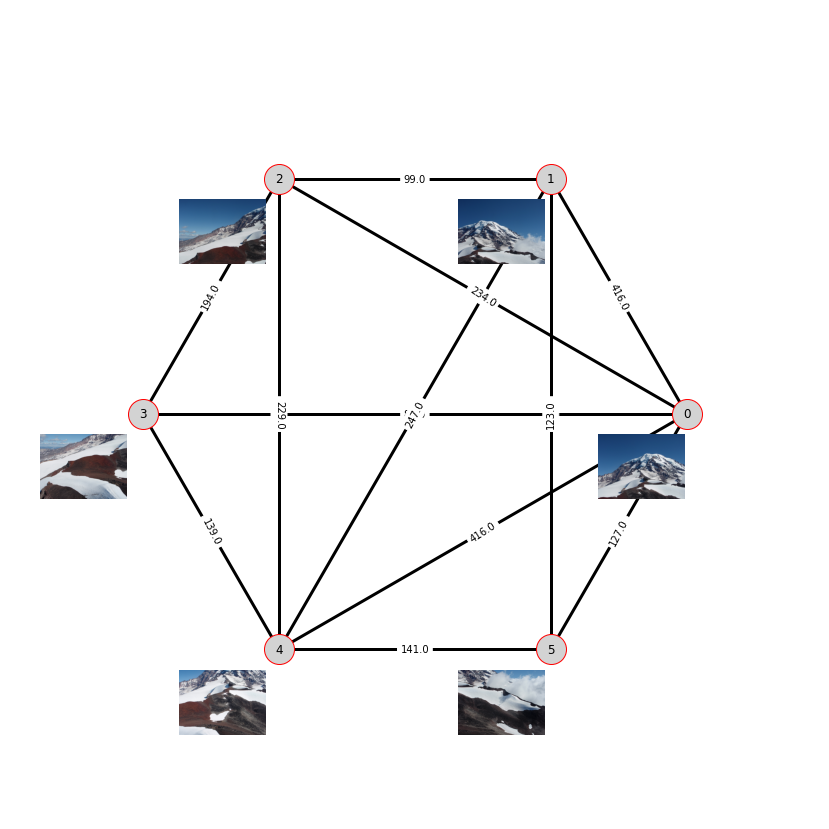

In [10]:
graph = buildAndPrintGraph(gamma = gamma, weight_matrix = weight_matrix)

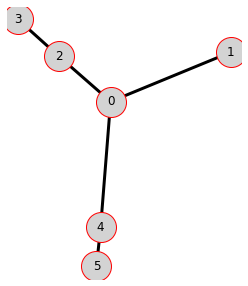

In [11]:
spanning_tree = nx.maximum_spanning_tree(graph)
pos=nx.kamada_kawai_layout(spanning_tree)
fig=plt.figure(figsize=(5,5))
ax=plt.subplot(111)
ax.set_aspect('equal')
nx.draw(spanning_tree,pos,ax=ax, width = 3, node_size=900,with_labels = True, edgecolors='red', node_color='lightgray')
plt.show()


In [12]:
warp_shape = [10000,10000]
root = get_root(gamma)
print(root)
stitched_image = stitch_images(imgs, spanning_tree, root, root, G, warp_shape)

0


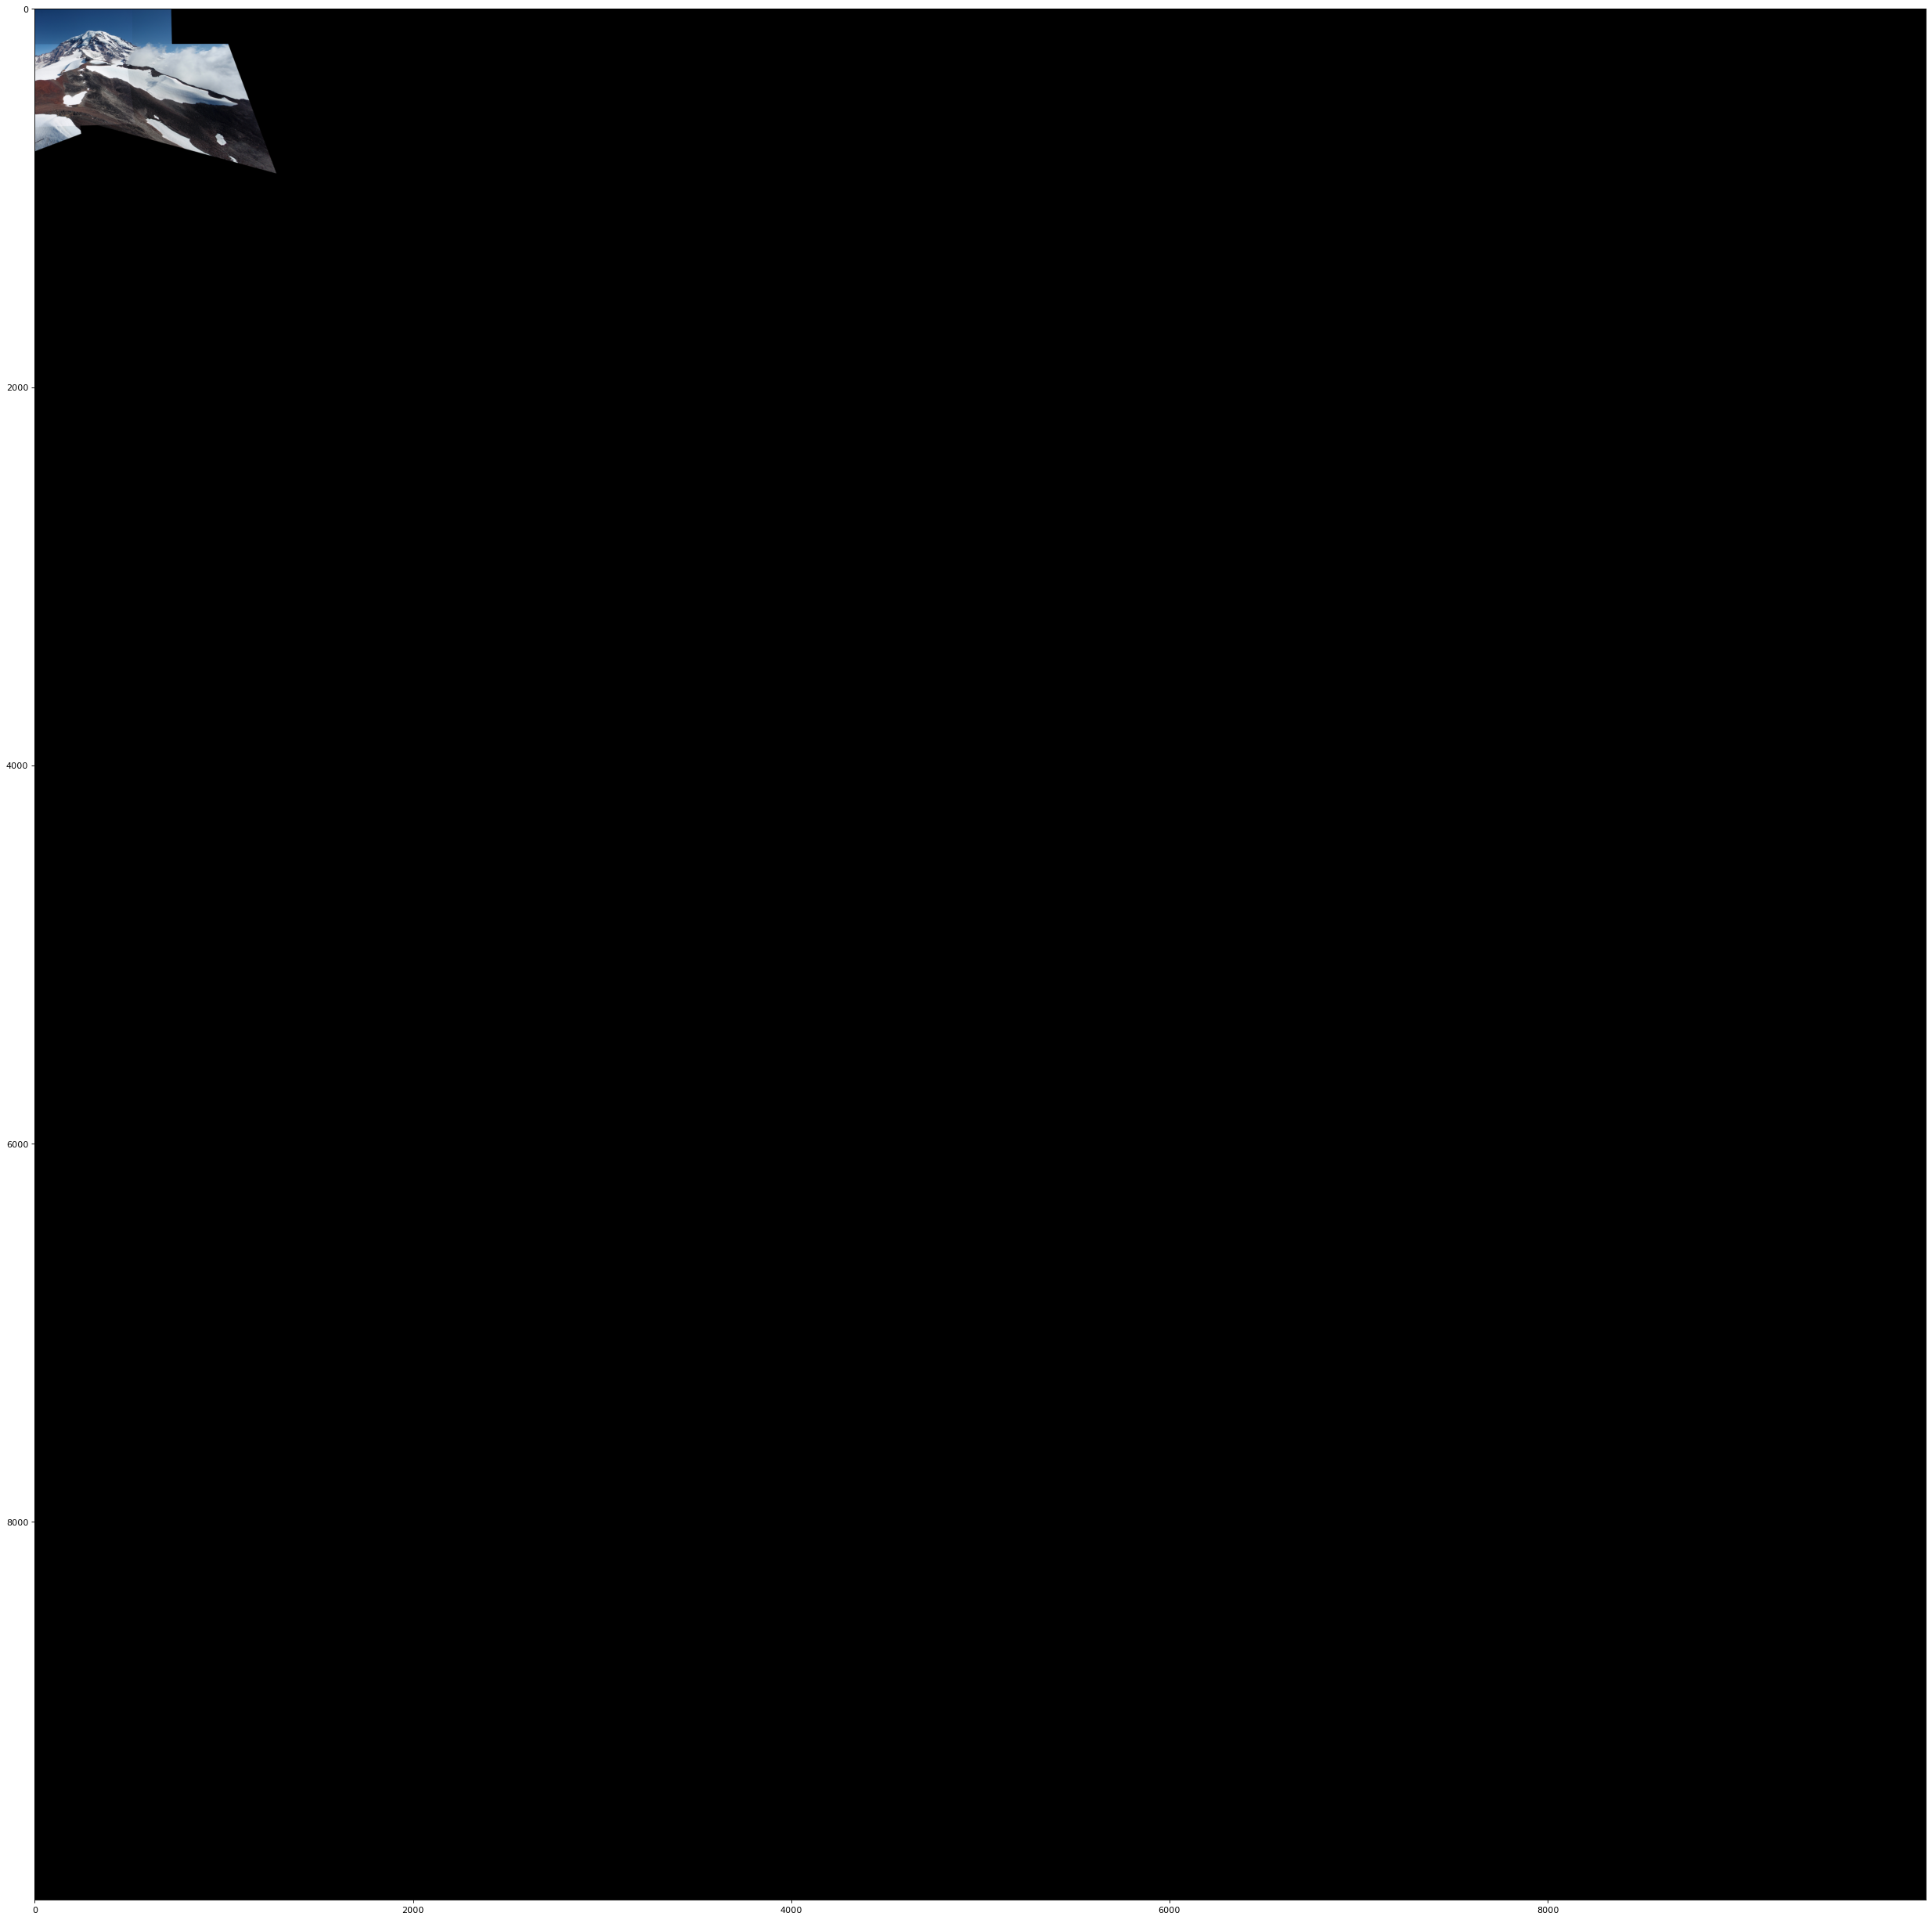

(<matplotlib.image.AxesImage at 0x26b6ba185e0>, None)

In [13]:
figure(figsize=(40, 40), dpi=80)
plt.imshow(stitched_image,),plt.show()